In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import torch
import torch.nn.functional as F
from torch import nn
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline  
%config InlineBackend.figure_format = 'retina'  
from pprint import pprint
import torch.optim as optim


In [3]:
np.random.seed(42)
X_train=np.random.uniform(-1,1,(200,2))
Y_train=np.logical_xor(X_train[:,0]>0,X_train[:,1]>0).astype(int)
X_test=np.random.uniform(-1,1,(200,2))
Y_test=np.logical_xor(X_test[:,0]>0,X_test[:,1]>0).astype(int)


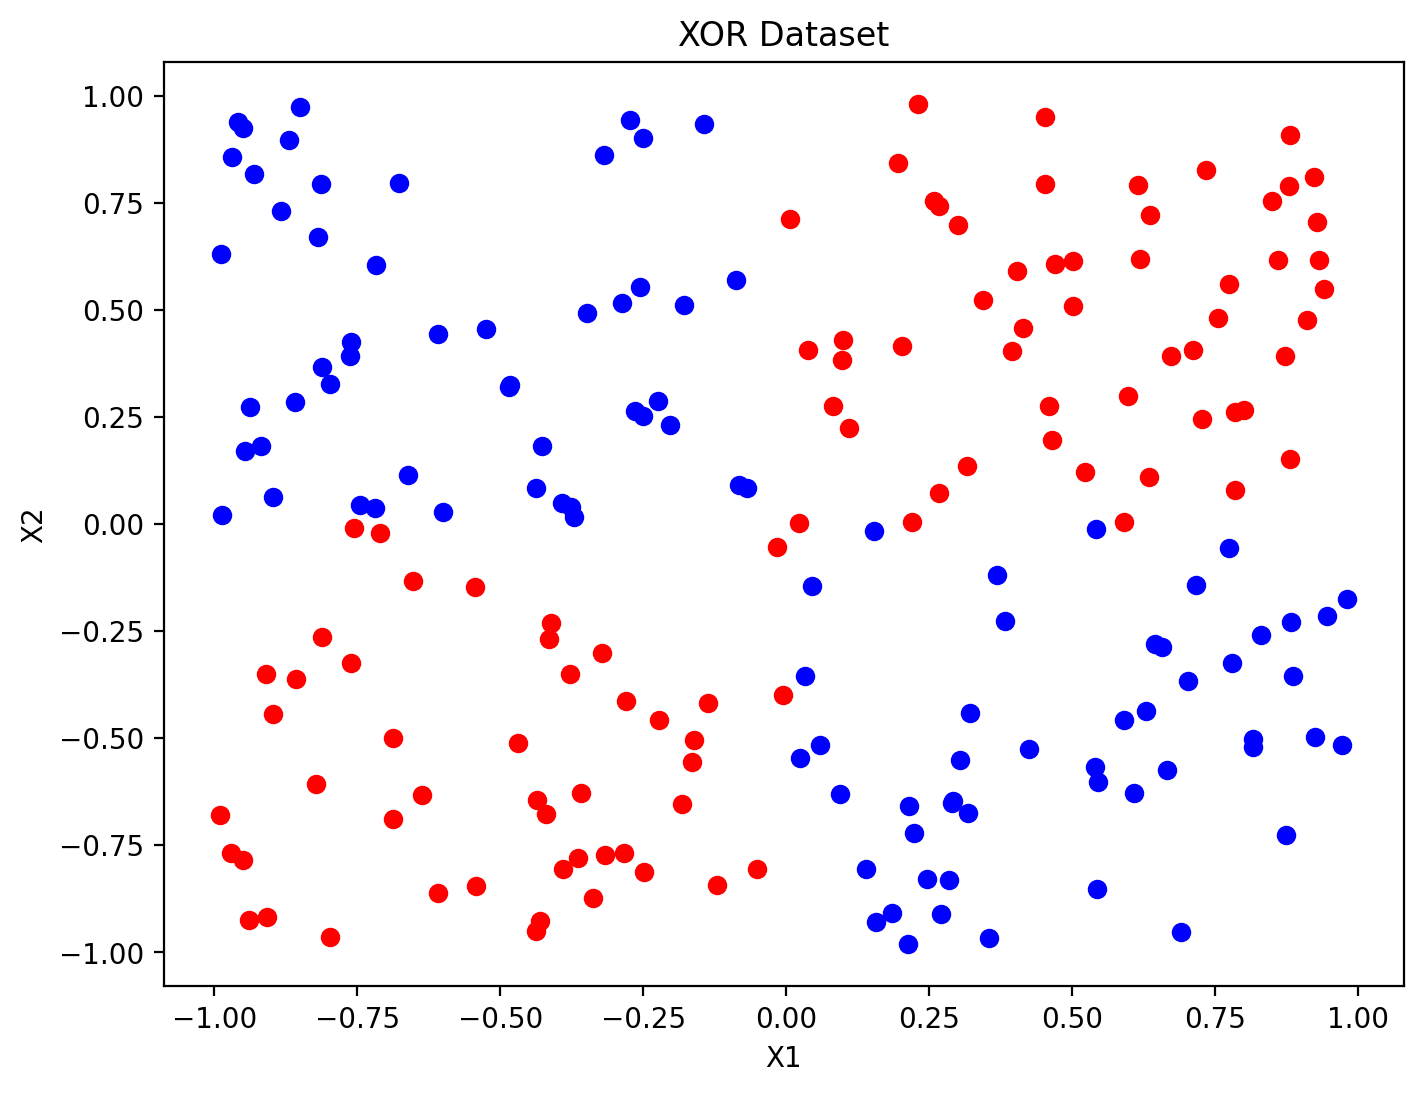

In [4]:
plt.figure(figsize=(8, 6))
for i in range(len(Y_train)):
    if Y_train[i] == 1:
        plt.scatter(X_train[i, 0], X_train[i, 1], c='blue')
    else:
        plt.scatter(X_train[i, 0], X_train[i, 1], c='red')

plt.xlabel("X1")
plt.ylabel("X2")
plt.title("XOR Dataset")
plt.show()

In [5]:
X_train_t = torch.tensor(X_train, dtype=torch.float32)
Y_train_t = torch.tensor(Y_train, dtype=torch.float32).unsqueeze(1) 

X_test_t = torch.tensor(X_test, dtype=torch.float32)
Y_test_t = torch.tensor(Y_test, dtype=torch.float32).unsqueeze(1)


In [6]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP,self).__init__()
        self.hidden=nn.Linear(2,10)
        self.output=nn.Linear(10,1)
    def forward(self,x):
        x=torch.relu(self.hidden(x))
        x=torch.sigmoid(self.output(x))
        return x
model=MLP()

In [7]:
criterion = nn.BCELoss() 
opt = torch.optim.Adam(model.parameters(), lr=0.01)

In [8]:
output=model(X_train_t)
output.shape


torch.Size([200, 1])

In [9]:
Y_train_t.shape

torch.Size([200, 1])

In [10]:
epochs=500
for i in range(1,epochs+1):
    model.train()
    output=model(X_train_t)
    loss=criterion(output,Y_train_t)
    opt.zero_grad()
    loss.backward()
    opt.step()
    if i%100==0:
        print("Epochs",i,"Loss: ", loss)

Epochs 100 Loss:  tensor(0.2743, grad_fn=<BinaryCrossEntropyBackward0>)
Epochs 200 Loss:  tensor(0.1250, grad_fn=<BinaryCrossEntropyBackward0>)
Epochs 300 Loss:  tensor(0.0887, grad_fn=<BinaryCrossEntropyBackward0>)
Epochs 400 Loss:  tensor(0.0714, grad_fn=<BinaryCrossEntropyBackward0>)
Epochs 500 Loss:  tensor(0.0606, grad_fn=<BinaryCrossEntropyBackward0>)


In [11]:
model.eval()
with torch.no_grad():
    output=model(X_test_t)
    pred=output.round()
    accuracy = (pred.eq(Y_test_t).sum() / float(Y_test_t.shape[0])).item()
    print(f'Test Accuracy: {accuracy * 100:.2f}%')


Test Accuracy: 98.00%


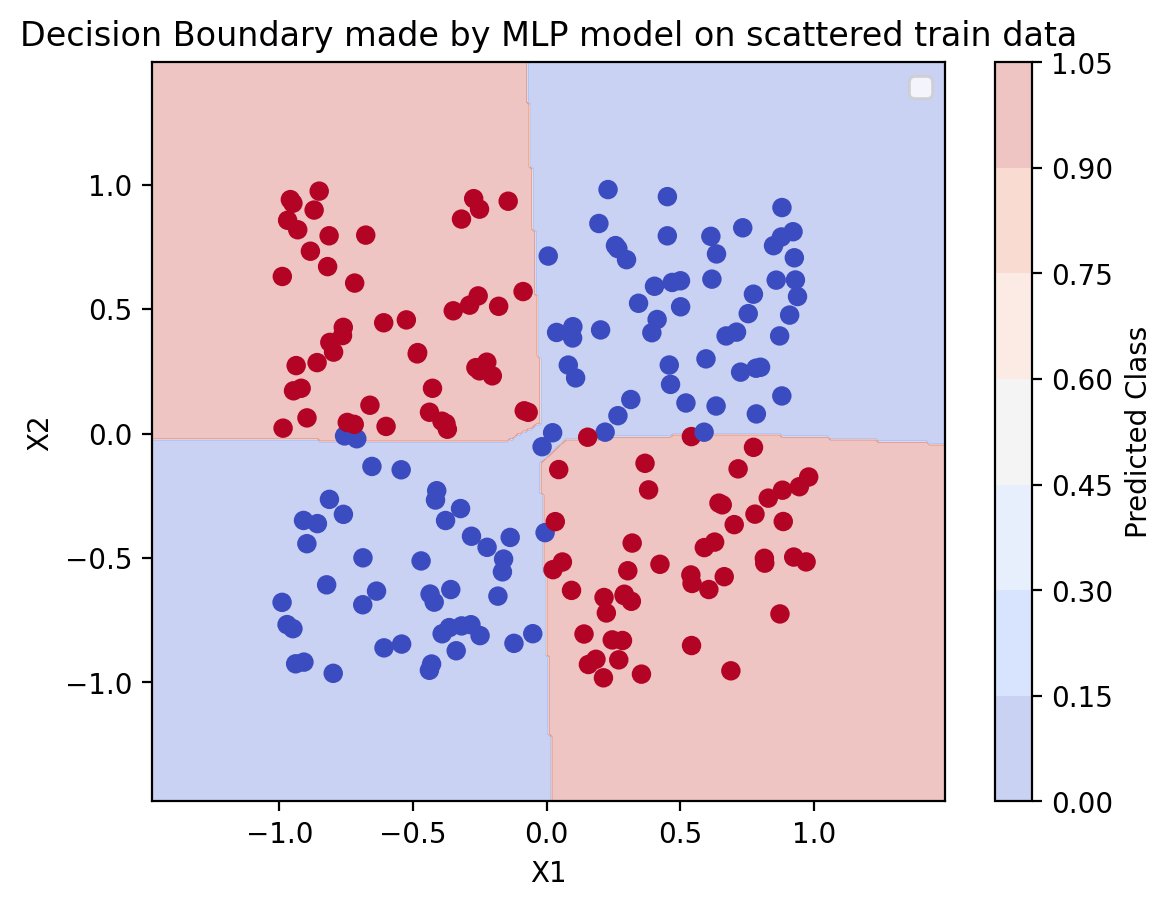

In [12]:
x_min, x_max = X_test[:, 0].min() - 0.5, X_test[:, 0].max() + 0.5
y_min, y_max = X_test[:, 1].min() - 0.5, X_test[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

grid_data = np.c_[xx.ravel(), yy.ravel()]
grid_data_t = torch.tensor(grid_data, dtype=torch.float32)
with torch.no_grad():
    Z = model(grid_data_t)
    Z = Z.round().numpy().reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
plt.colorbar(label='Predicted Class')
plt.scatter(X_train[:, 0], X_train[:, 1], c=Y_train, cmap='coolwarm')
plt.xlabel("X1")
plt.ylabel("X2")
plt.title("Decision Boundary made by MLP model on scattered train data")
plt.legend()
plt.show()

**The basic MLP model achieved the highest accuracy, suggesting it effectively captured the XOR pattern. Its ability to learn non-linear relationships without additional regularization indicates a strong baseline performance for this dataset. There might be some changes in accuracy based on dataset provided.**

# **MLP w/ L1 regularization**

In [13]:
def l1_reg(model, lamda):
    l1_norm=sum(p.abs().sum() for p in model.parameters())
    return lamda*l1_norm

X_val_t = X_train_t[160:]
Y_val_t = Y_train_t[160:]
X_train_t = X_train_t[:160]
Y_train_t = Y_train_t[:160]


In [14]:
l1_values = [0.001, 0.005, 0.01, 0.015, 0.02]  
epochs = 500  
val_accs = []  

best_lambda_l1 = None  
best_val_accuracy = -1  

In [15]:
for lambda_l1 in l1_values:
    model = MLP()  
    criterion = nn.BCELoss()  # Loss function
    optimizer = optim.Adam(model.parameters(), lr=0.01) 

    for epoch in range(1, epochs + 1):
        model.train()
        output = model(X_train_t)
        loss = criterion(output, Y_train_t) + l1_reg(model, lambda_l1)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        val_output = model(X_val_t)
        val_pred = val_output.round()
        val_accuracy = (val_pred.eq(Y_val_t).sum() / float(Y_val_t.shape[0])).item() * 100
        val_accs.append(val_accuracy)
        print(f'L1 Lambda: {lambda_l1}, Validation Accuracy: {val_accuracy:.2f}%')

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_lambda_l1 = lambda_l1

L1 Lambda: 0.001, Validation Accuracy: 97.50%
L1 Lambda: 0.005, Validation Accuracy: 97.50%
L1 Lambda: 0.01, Validation Accuracy: 80.00%
L1 Lambda: 0.015, Validation Accuracy: 52.50%
L1 Lambda: 0.02, Validation Accuracy: 47.50%


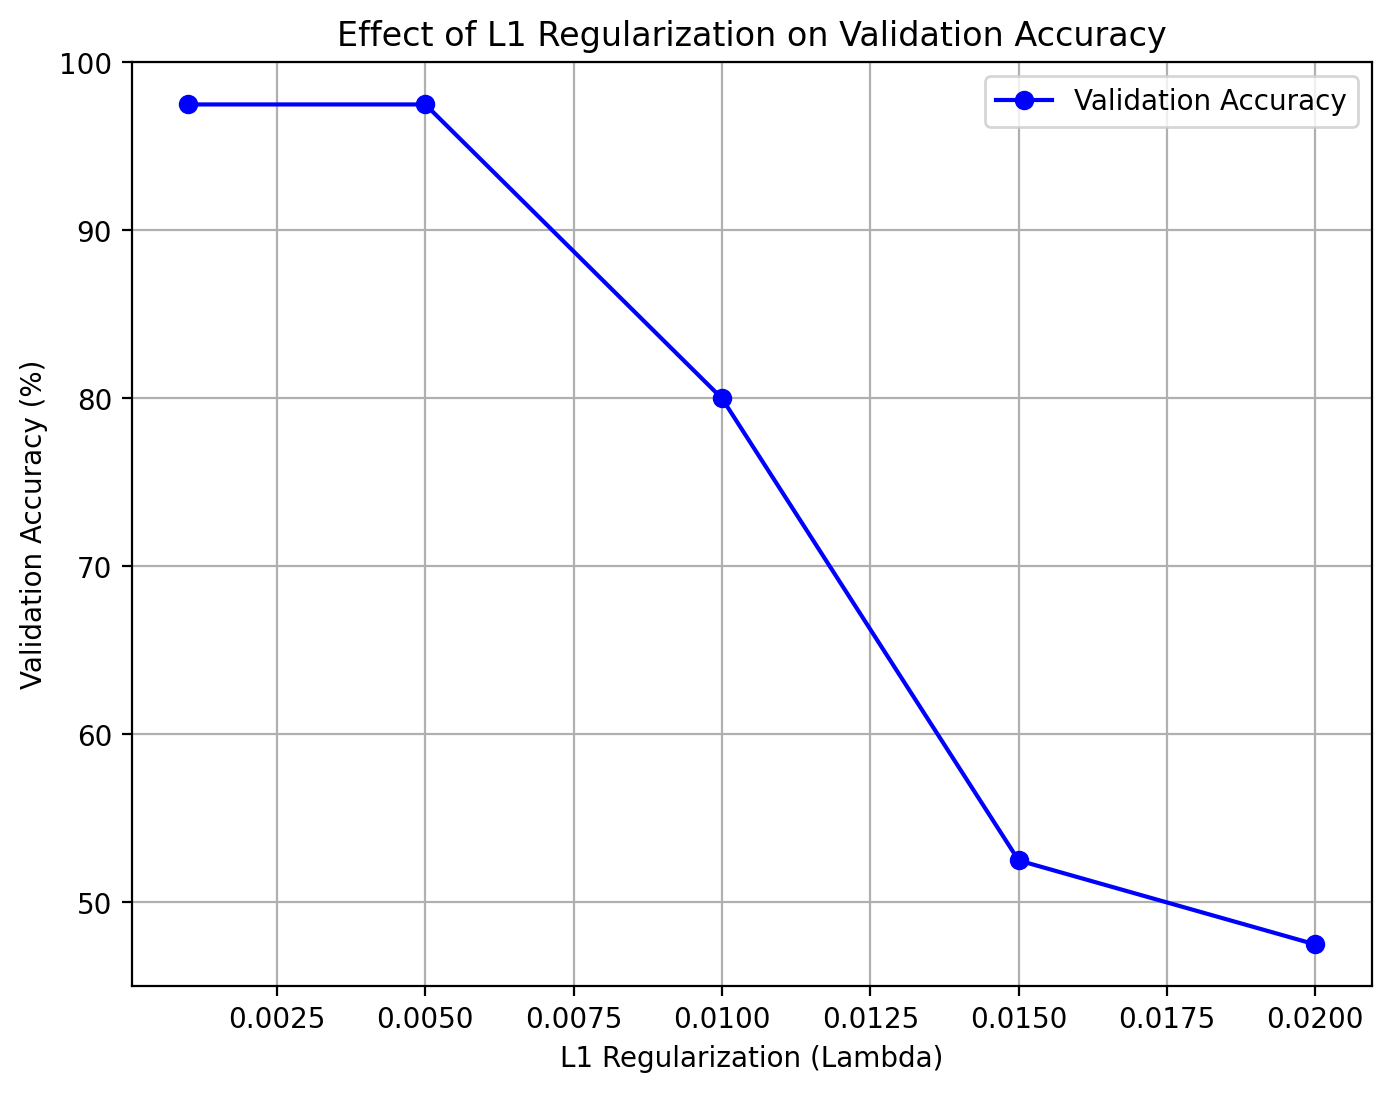

In [16]:
plt.figure(figsize=(8, 6))
plt.plot(l1_values, val_accs, marker='o', label='Validation Accuracy', color='blue')
plt.xlabel('L1 Regularization (Lambda)')
plt.ylabel('Validation Accuracy (%)')
plt.title('Effect of L1 Regularization on Validation Accuracy')
plt.grid(True)
plt.legend()
plt.show()


In [17]:
model = MLP()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for epoch in range(1, epochs + 1):
    model.train()
    output = model(X_train_t)
    loss = criterion(output, Y_train_t) + l1_reg(model, best_lambda_l1)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

model.eval()
with torch.no_grad():
    output = model(X_test_t)
    pred = output.round()
    accuracy = (pred.eq(Y_test_t).sum() / float(Y_test_t.shape[0])).item()
    print(f'Test Accuracy: {accuracy * 100:.2f}%')


Epoch 100, Loss: 0.3326
Epoch 200, Loss: 0.1686
Epoch 300, Loss: 0.1386
Epoch 400, Loss: 0.1287
Epoch 500, Loss: 0.1239
Test Accuracy: 97.00%


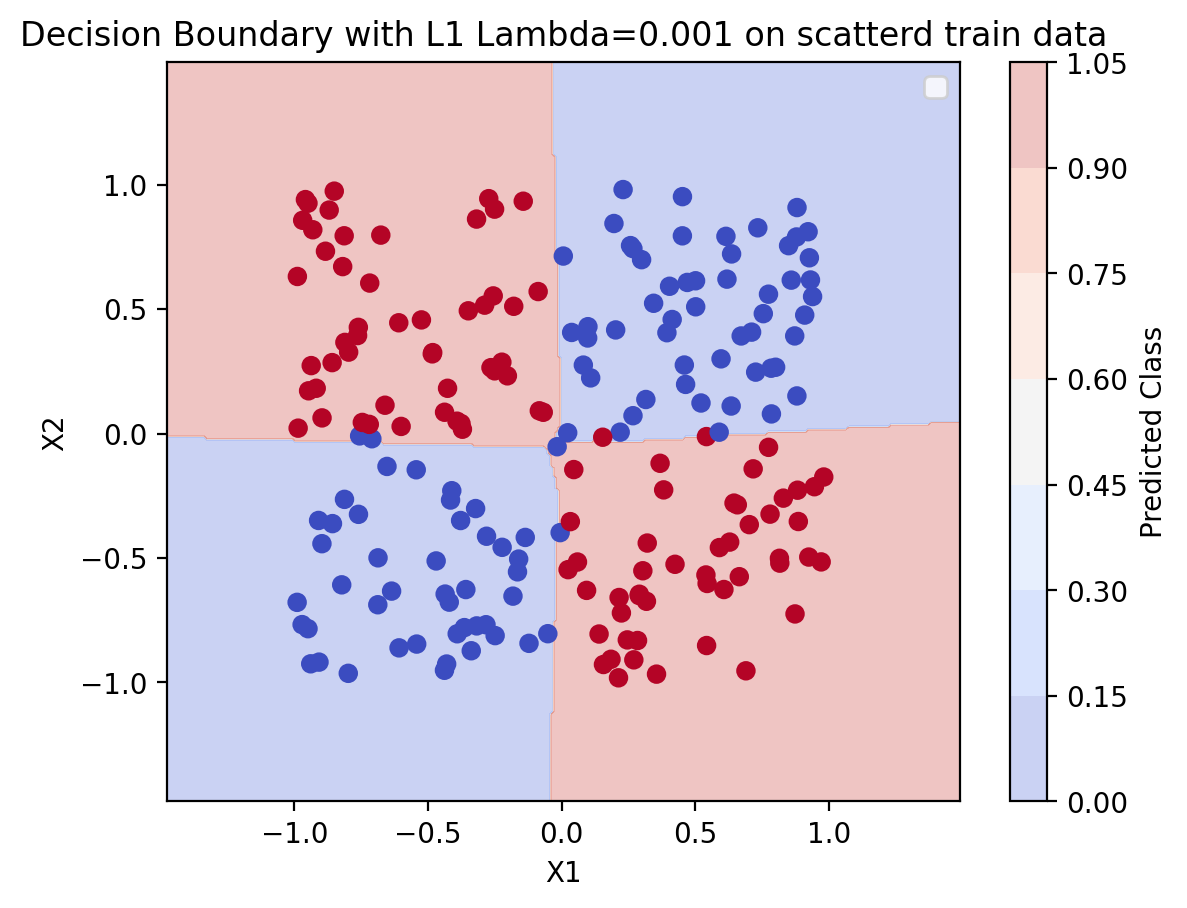

In [18]:

x_min, x_max = X_test[:, 0].min() - 0.5, X_test[:, 0].max() + 0.5
y_min, y_max = X_test[:, 1].min() - 0.5, X_test[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

grid_data = np.c_[xx.ravel(), yy.ravel()]
grid_data_t = torch.tensor(grid_data, dtype=torch.float32)
with torch.no_grad():
    Z = model(grid_data_t)
    Z = Z.round().numpy().reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
plt.colorbar(label='Predicted Class')
plt.scatter(X_train[:, 0], X_train[:, 1], c=Y_train, cmap='coolwarm')
plt.xlabel("X1")
plt.ylabel("X2")
plt.title(f"Decision Boundary with L1 Lambda={best_lambda_l1} on scatterd train data")
plt.legend()
plt.show()


**We got slight drop in accuracy compared to the basic MLP which suggests that while L1 regularization can be helpful to enforce sparsity, it may slightly constrain the model's ability to learn the XOR pattern. However, the impact is minimal, indicating the model still performs well with regularization. Also there can also be reason such as L1 reg and L2 reg works efficient mostly when we dont have sufficient number of test or train data, but in our cases we have enough data points.**

# **MLP w/ L2**

In [19]:
l2_values = [0.001, 0.005, 0.01, 0.015, 0.02]  
epochs = 100 
val_accs = [] 

best_lambda_l2 = None  
best_val_accuracy = -1 

In [20]:
for lambda_l2 in l2_values:
    model = MLP()  
    criterion = nn.BCELoss()  
    optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=lambda_l2) 

    for epoch in range(1, epochs + 1):
        model.train()
        output = model(X_train_t)
        loss = criterion(output, Y_train_t)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        val_output = model(X_val_t)
        val_pred = val_output.round()
        val_accuracy = (val_pred.eq(Y_val_t).sum() / float(Y_val_t.shape[0])).item() * 100
        val_accs.append(val_accuracy)
        print(f'L2 Lambda: {lambda_l2}, Validation Accuracy: {val_accuracy:.2f}%')

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_lambda_l2 = lambda_l2


L2 Lambda: 0.001, Validation Accuracy: 95.00%
L2 Lambda: 0.005, Validation Accuracy: 100.00%
L2 Lambda: 0.01, Validation Accuracy: 92.50%
L2 Lambda: 0.015, Validation Accuracy: 97.50%
L2 Lambda: 0.02, Validation Accuracy: 97.50%


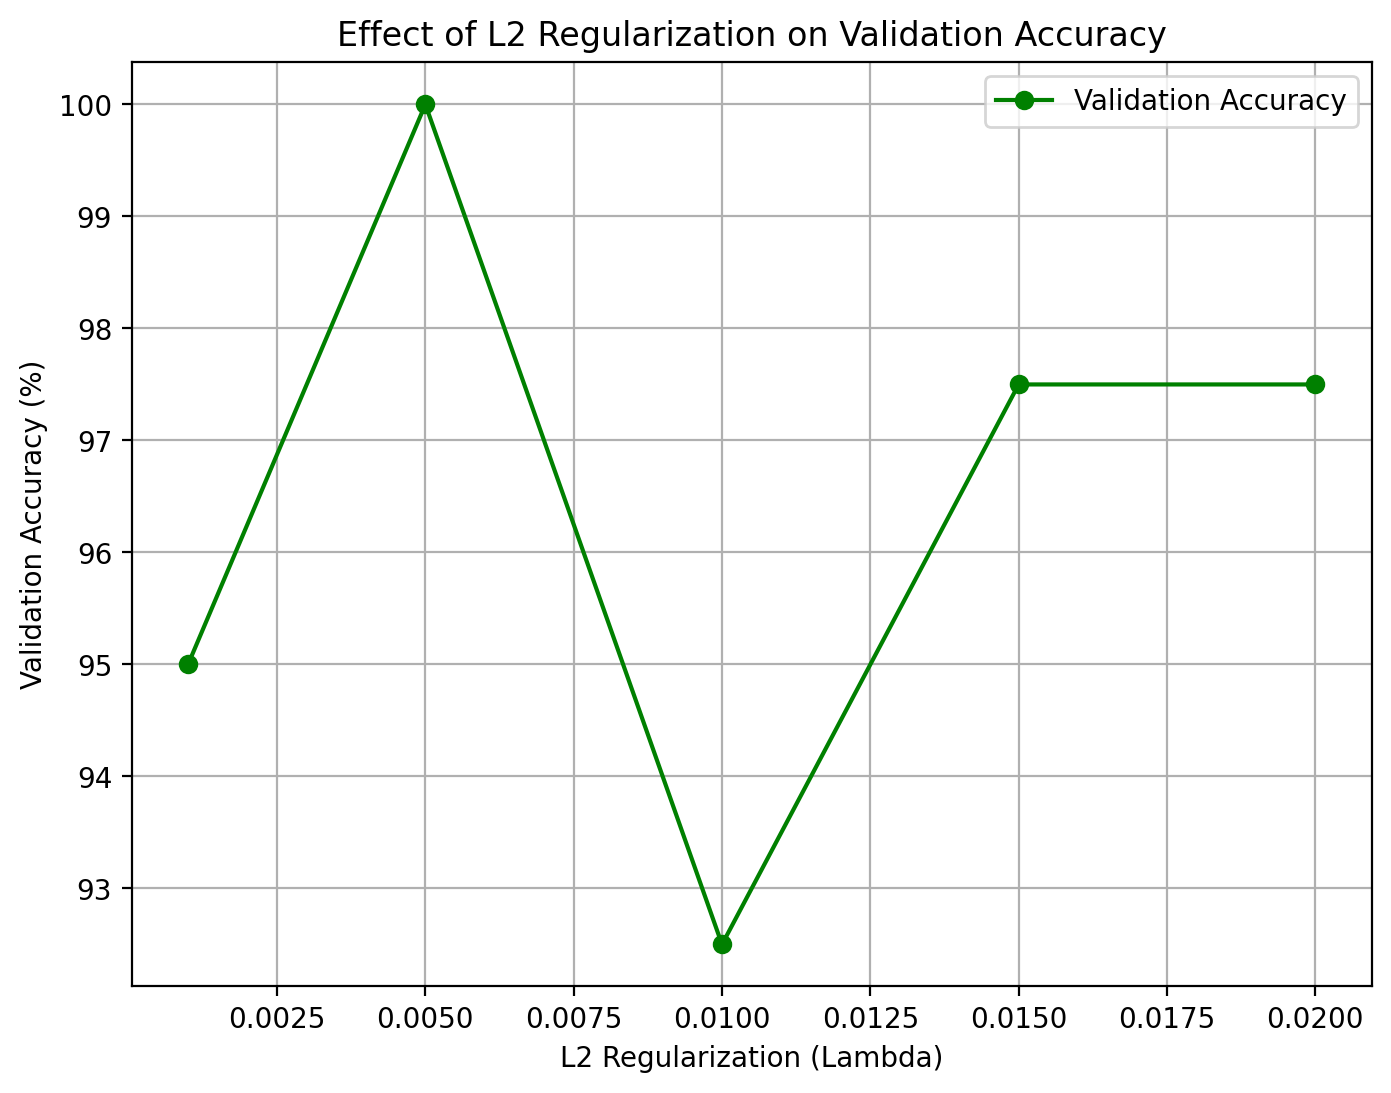

In [21]:
plt.figure(figsize=(8, 6))
plt.plot(l2_values, val_accs, marker='o', label='Validation Accuracy', color='green')
plt.xlabel('L2 Regularization (Lambda)')
plt.ylabel('Validation Accuracy (%)')
plt.title('Effect of L2 Regularization on Validation Accuracy')
plt.grid(True)
plt.legend()
plt.show()

In [22]:
model = MLP()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=best_lambda_l2)
epochs=500
for epoch in range(1, epochs + 1):
    model.train()
    output = model(X_train_t)
    loss = criterion(output, Y_train_t)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

Epoch 100, Loss: 0.3461
Epoch 200, Loss: 0.2482
Epoch 300, Loss: 0.1465
Epoch 400, Loss: 0.1431
Epoch 500, Loss: 0.1417


In [23]:
model.eval()
with torch.no_grad():
    output = model(X_test_t)
    pred = output.round()
    accuracy = (pred.eq(Y_test_t).sum() / float(Y_test_t.shape[0])).item()
    print(f'Test Accuracy: {accuracy * 100:.2f}%')

Test Accuracy: 96.00%


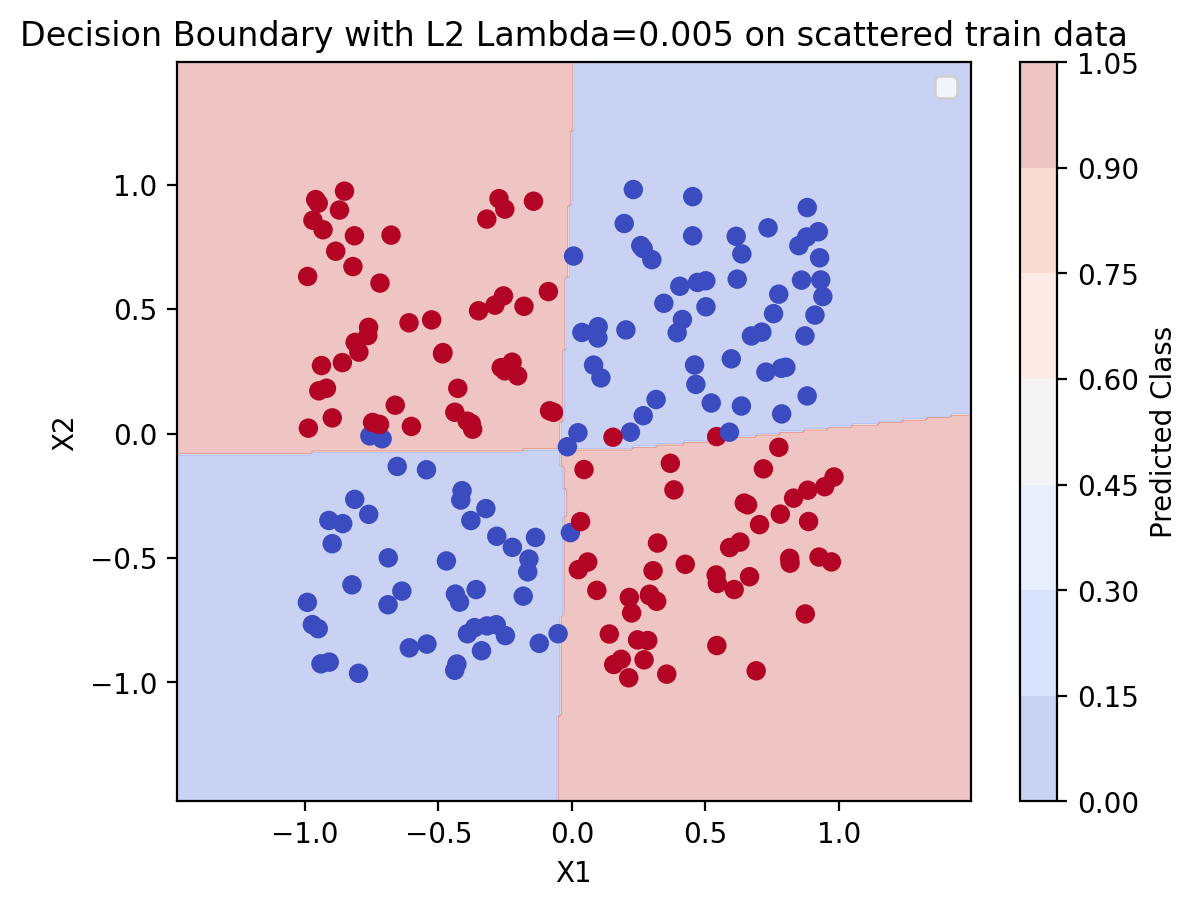

In [24]:
x_min, x_max = X_test[:, 0].min() - 0.5, X_test[:, 0].max() + 0.5
y_min, y_max = X_test[:, 1].min() - 0.5, X_test[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

grid_data = np.c_[xx.ravel(), yy.ravel()]
grid_data_t = torch.tensor(grid_data, dtype=torch.float32)
with torch.no_grad():
    Z = model(grid_data_t)
    Z = Z.round().numpy().reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
plt.colorbar(label='Predicted Class')
plt.scatter(X_train[:, 0], X_train[:, 1], c=Y_train, cmap='coolwarm')
plt.xlabel("X1")
plt.ylabel("X2")
plt.title(f"Decision Boundary with L2 Lambda={best_lambda_l2} on scattered train data")
plt.legend()
plt.show()

**Similar to L1, L2 regularization introduces a slight decrease in accuracy. L2 regularization helps to prevent overfitting by penalizing large weights, but in this case, it shows a minor effect on performance. The model remains robust, capturing the XOR pattern effectively.**

# additional Feature

In [25]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split

In [26]:
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

In [27]:
X_train_torch = torch.FloatTensor(X_train)
y_train_torch = torch.FloatTensor(Y_train).unsqueeze(1)
X_test_torch = torch.FloatTensor(X_test)
y_test_torch = torch.FloatTensor(Y_test).unsqueeze(1)

In [28]:
X_train_poly_torch = torch.FloatTensor(X_train_poly)
X_test_poly_torch = torch.FloatTensor(X_test_poly)

In [29]:
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, 1)
    
    def forward(self, x):
        return torch.sigmoid(self.linear(x))

In [30]:
input_dim = X_train_poly.shape[1]
model = LogisticRegressionModel(input_dim)
criterion = nn.BCELoss() 
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

In [31]:
epochs = 500
for epoch in range(1,epochs+1):
    outputs = model(X_train_poly_torch)
    loss = criterion(outputs, y_train_torch)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch) % 100 == 0:
        print(f'Epoch [{epoch}], Loss: {loss.item():.4f}')

Epoch [100], Loss: 0.5700
Epoch [200], Loss: 0.4894
Epoch [300], Loss: 0.4372
Epoch [400], Loss: 0.4004
Epoch [500], Loss: 0.3729


In [32]:
with torch.no_grad():
    y_pred_train = model(X_train_poly_torch).round()
    y_pred_test = model(X_test_poly_torch).round()
    
    train_accuracy = (y_pred_train.eq(y_train_torch).sum() / float(y_train_torch.shape[0])).item() * 100
    test_accuracy = (y_pred_test.eq(y_test_torch).sum() / float(y_test_torch.shape[0])).item() * 100

print(f'Train Accuracy: {train_accuracy:.2f}%')
print(f'Test Accuracy: {test_accuracy:.2f}%')


Train Accuracy: 97.00%
Test Accuracy: 93.50%


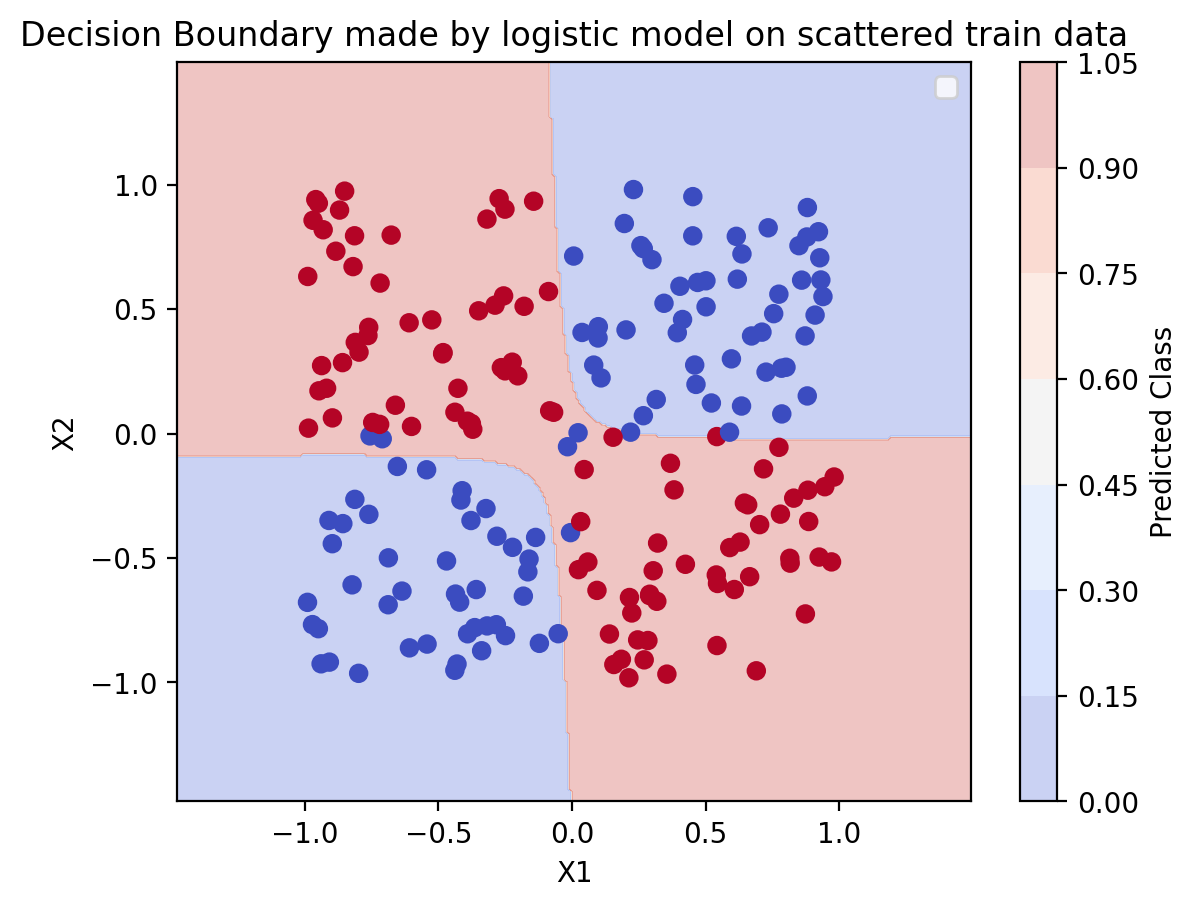

In [33]:
x_min, x_max = X_test[:, 0].min() - 0.5, X_test[:, 0].max() + 0.5
y_min, y_max = X_test[:, 1].min() - 0.5, X_test[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

grid_data = np.c_[xx.ravel(), yy.ravel()]
grid_data_poly = poly.transform(grid_data)  
grid_data_t = torch.tensor(grid_data_poly, dtype=torch.float32)

with torch.no_grad():
    Z = model(grid_data_t)
    Z = Z.round().numpy().reshape(xx.shape)

# Plot decision surface
plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
plt.colorbar(label='Predicted Class')
plt.scatter(X_train[:, 0], X_train[:, 1], c=Y_train, cmap='coolwarm')
plt.xlabel("X1")
plt.ylabel("X2")
plt.title("Decision Boundary made by logistic model on scattered train data")
plt.legend()
plt.show()

**While logistic regression with polynomial features improves upon a simple linear model, its performance is lower than the MLP variants. This highlights the inherent complexity of the XOR problem, where more advanced models (like MLP) with non-linear capabilities excel better compared to logistic regression with engineered features.**

#### overall observation:

**Model--->accuracy on test data**

**1)MLP                          ->98.00%**

**2)MLP+L1                       ->97.00%**

**3)MLP+L2                       ->96.00%**

**4)Additional 2 degree feature  ->93.50%**